In [3]:
from google.colab import drive 

#掛載雲端硬碟
drive.mount('/content/gdrive')  

Mounted at /content/gdrive


51888128/51877672 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 1664)              12642880  
                                                                 
 dense (Dense)               (None, 4)                 6660      
                                                                 
Total params: 12,649,540
Trainable params: 12,491,140
Non-trainable params: 158,400
_________________________________________________________________
Epoch 1/50
133/133 [==============================] - 56s 217ms/step - loss: 0.8406 - acc: 0.6716 - precision: 0.7750 - recall: 0.5428 - val_loss: 0.7650 - val_acc: 0.7420 - val_precision: 0.8769 - val_recall: 0.5282
Epoch 2/50
133/133 [==============================] - 20s 150ms/step - loss: 0.5490 - acc: 0.7944 - precision: 0.8402 - recall: 0.7456 - val_loss: 0.535

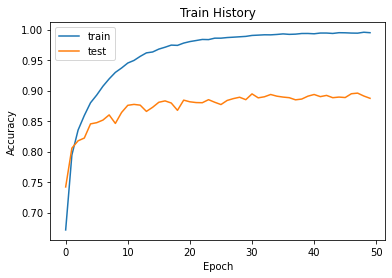

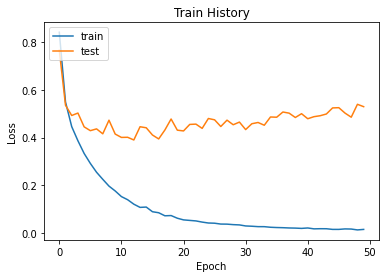

success


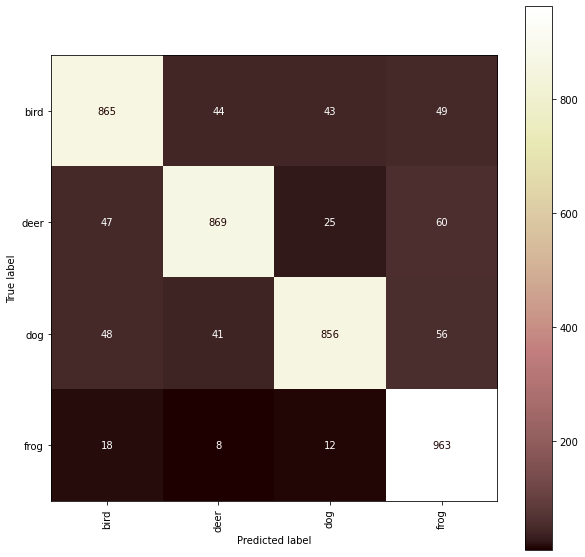

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      1001
           1       0.90      0.87      0.89      1001
           2       0.91      0.86      0.88      1001
           3       0.85      0.96      0.90      1001

    accuracy                           0.89      4004
   macro avg       0.89      0.89      0.89      4004
weighted avg       0.89      0.89      0.89      4004



<Figure size 432x288 with 0 Axes>

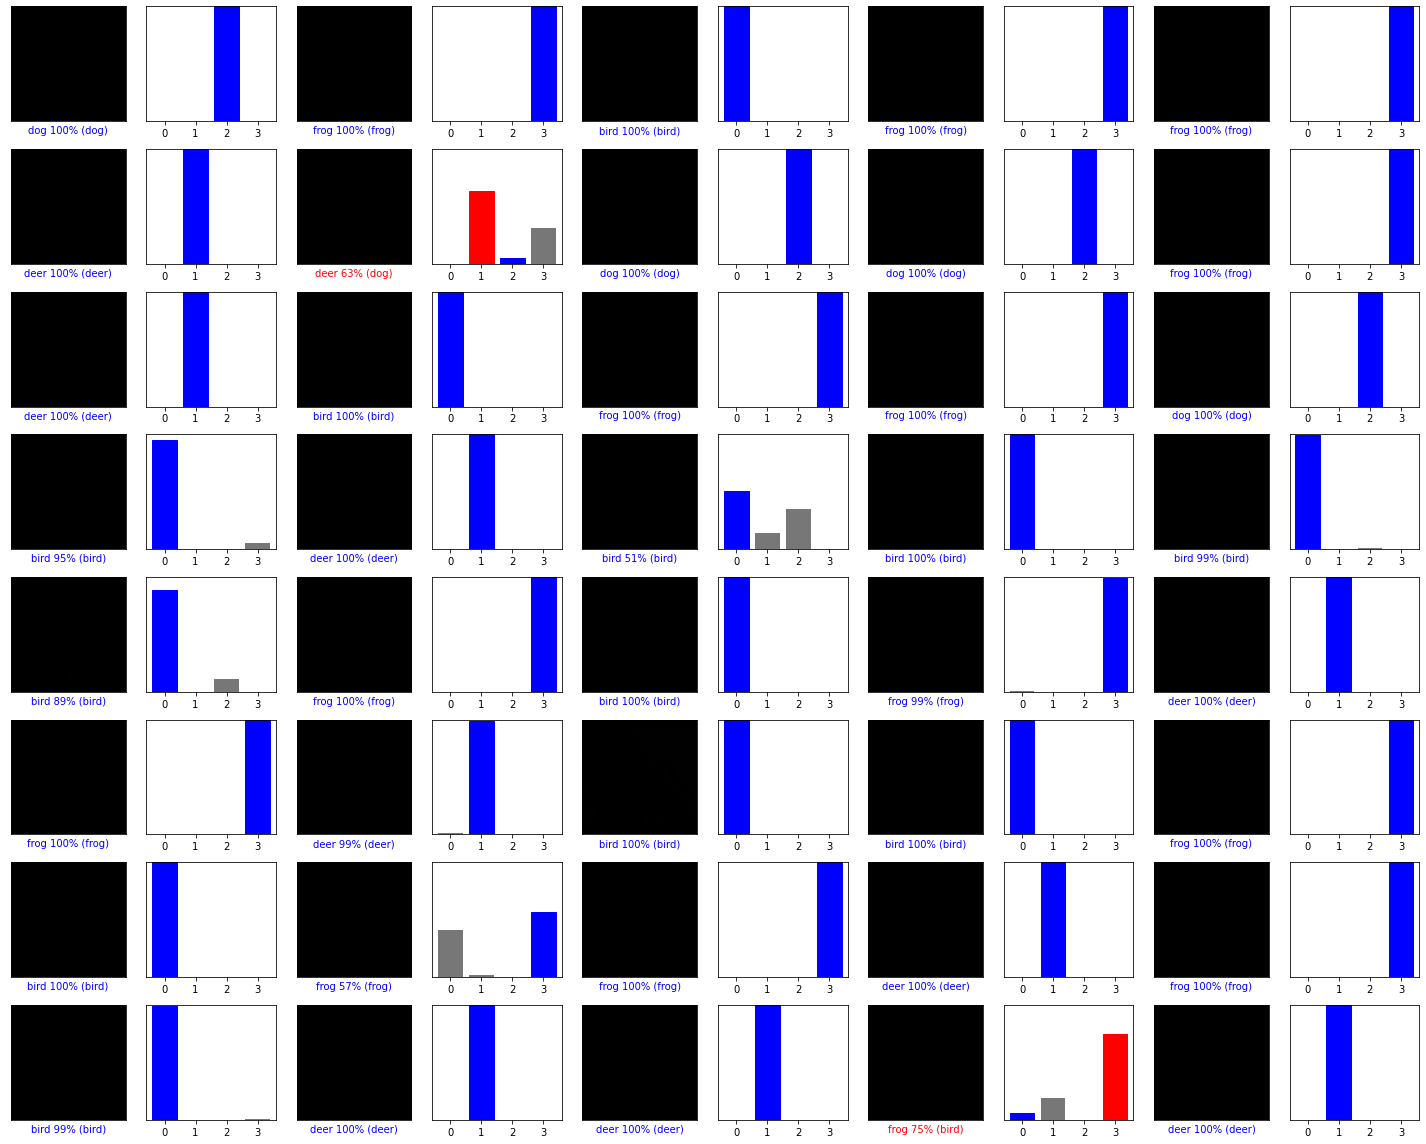

In [4]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

num_classes = 4
batch_size = 150
epochs = 50

def load_data():
    train_data = np.empty((len(os.listdir("/content/gdrive/MyDrive/ColabNotebooks/DataBase")), 32, 32, 3), dtype = "float32")
    train_labels = np.empty((len(os.listdir("/content/gdrive/MyDrive/ColabNotebooks/DataBase")), ), dtype = "uint8")
    test_data = np.empty((len(os.listdir("/content/gdrive/MyDrive/ColabNotebooks/Test")), 32, 32, 3), dtype = "float32")
    test_labels = np.empty((len(os.listdir("/content/gdrive/MyDrive/ColabNotebooks/Test")), ), dtype = "uint8")
    
    i = 0
    for p in os.listdir("/content/gdrive/MyDrive/ColabNotebooks/DataBase"):
        img = Image.open("/content/gdrive/MyDrive/ColabNotebooks/DataBase/" + p)
        arr = np.asarray(img, dtype = "float32")
        train_data[i, :, :, :] = arr
        train_labels[i] = int(p.split('.')[0])
        i += 1
        
    i = 0
    for p in os.listdir("/content/gdrive/MyDrive/ColabNotebooks/Test"):
        img = Image.open("/content/gdrive/MyDrive/ColabNotebooks/Test/" + p)
        arr = np.asarray(img, dtype = "float32")
        test_data[i, :, :, :] = arr
        test_labels[i] = int(p.split('.')[0])
        i += 1
        
    return (train_data, train_labels), (test_data, test_labels)

(x_train, y_train), (x_test, y_test) = load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

y_cat_train = to_categorical(y_train, num_classes)
y_cat_test = to_categorical(y_test, num_classes)

model = Sequential()
# start from this
model.add(DenseNet169(input_shape=(32, 32, 3), include_top=False, weights='imagenet', pooling='avg'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=["acc", Precision(), Recall()])
model.summary()

data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(x_train, y_cat_train, batch_size)
steps_per_epoch = x_train.shape[0] // batch_size
train_history = model.fit(train_generator, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_data=(x_test, y_cat_test), 
              verbose = 1
#               callbacks=[early_stop],
             )

score = model.evaluate(x_train, y_cat_train, verbose=0)
print('Train accuracy:', score[1])

score = model.evaluate(x_test, y_cat_test, verbose=0)
print('Test accuracy:', score[1])
print('Precision:', score[2])
print('Recall:', score[3])
print('F1-score:', 2.0/(1.0/score[2] + 1.0/score[3]))

import matplotlib.pyplot as plt
def show_train_history(train_type,test_type):
    plt.plot(train_history.history[train_type])
    plt.plot(train_history.history[test_type])
    plt.title('Train History')
    if train_type == 'acc':
        plt.ylabel('Accuracy')
    else:
        plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

show_train_history('acc','val_acc')
show_train_history('loss','val_loss')

try:
    model.save_weights("S6_150.h5")
    print("success")
except:
    print("error")


from sklearn.metrics import classification_report, confusion_matrix

predict_x = model.predict(x_test) 
y_pred = np.argmax(predict_x,axis=1)

cm = confusion_matrix(y_test, y_pred)
from sklearn.metrics import ConfusionMatrixDisplay

# Define the labels of the dataset
labels = ['bird', 'deer', 'dog', 'frog']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# NOTE: Fill all variables here with default values of the plot_confusion_matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='pink')

plt.show()

print(classification_report(y_test, y_pred))

plt.subplots_adjust(hspace=0.4)

predictions = model.predict(x_test)

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img.astype('uint8'), cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(f"{labels[int(predicted_label)]} {100*np.max(predictions_array):2.0f}% ({labels[int(true_label)]})", 
               color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, int(true_label[i])
    plt.grid(False)
    plt.xticks(range(4))
    plt.yticks([])
    thisplot = plt.bar(range(4), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 8
num_cols = 5
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, predictions[i], y_test, x_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()